*First compiled: August 17, 2017.*

# Benchmarking robustness for the minimal example

In [1]:
import itertools
from collections import namedtuple, OrderedDict
import numpy as np
import scanpy.api as sc
import networkx as nx
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=80, color_map='Greys')
sc.logging.print_version_and_date()

Running Scanpy 1.0.4+63.gef4d1c0.dirty on 2018-05-07 03:44.


You should run [minimal_examples](minimal_examples.ipynb) before running this notebook to read the file exported there.

In [2]:
adata = sc.read('krumsiek11_blobs')

## The reference graph

Generate a reference graph, which is partitioned into groups using a very high resolution. This generates a very detailed "ground truth", which is hard to reproduce in a robustness study. By contrast, a "ground truth" involving coarse-grained clusters and a trivial graph topology, would be hard to reproduce.

We cannot meaningfully draw the result with a tree layout, as the clusters have non-tree structure; instead, we use the Fruchterman-Reingold layout.

saving figure to file ./figures/paga_compare_reference.pdf


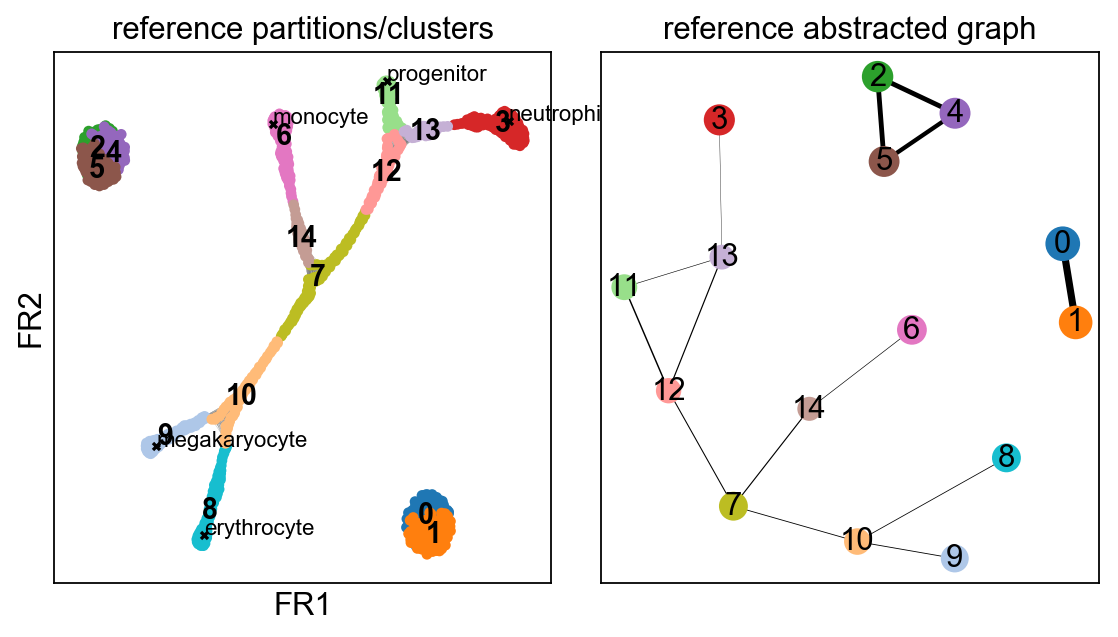

In [3]:
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.paga(adata)
sc.pl.paga_compare(adata, basis='draw_graph_fr',
           title='reference partitions/clusters',
           title_graph='reference abstracted graph',               
           layout='fr', save='_reference')
adata_reference = adata.copy()

## How to assess robustness?

Consider a new run of graph abstraction with highly different parameters.

saving figure to file ./figures/paga_compare_new.pdf


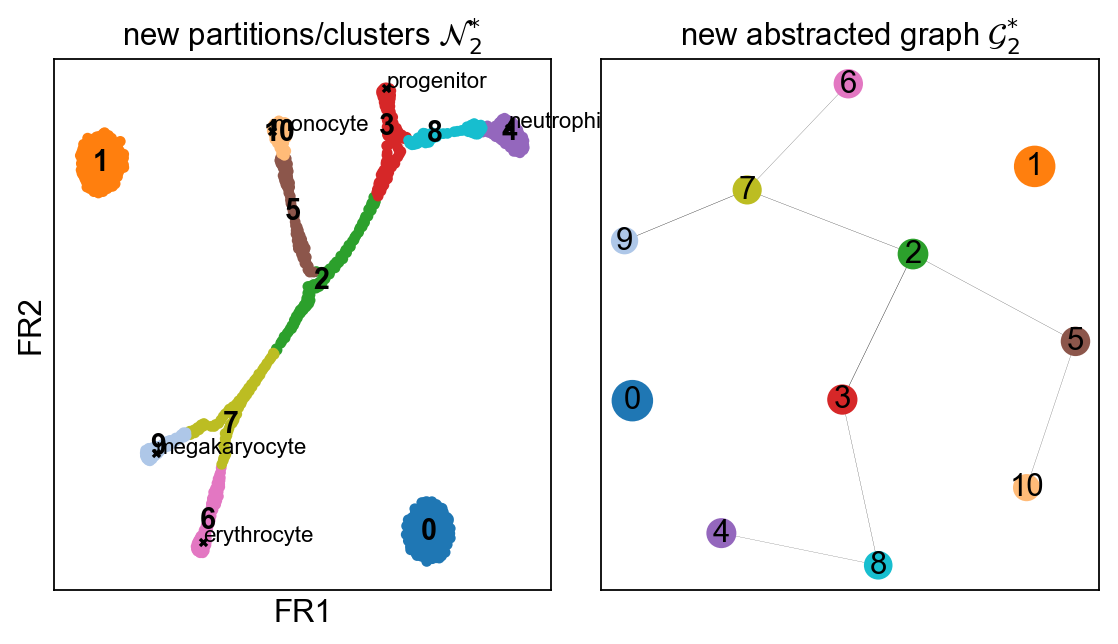

In [4]:
adata_new = sc.pp.neighbors(adata, n_neighbors=10, copy=True)
sc.tl.louvain(adata_new, resolution=0.8)
sc.tl.paga(adata_new)
sc.pl.paga_compare(
    adata_new, basis='draw_graph_fr', layout='fr', threshold=0.005,
    title='new partitions/clusters $\mathcal{N}_2^{*}$',
    title_graph='new abstracted graph $\mathcal{G}_2^{*}$',
    save='_new')

Inspecting the reference and the new abstracted graph, we would say that both agree.

### 1. Determine to which new labels the reference labels correspond.

We first need to identify the reference groups with the new groups in `adata_new`.

For this, we compute the relative overlap between both clusterings. Relative can either mean a normalization with respect to the new groups computed (rows sum to 1).

saving figure to file ./figures/matrix_norm_new.pdf


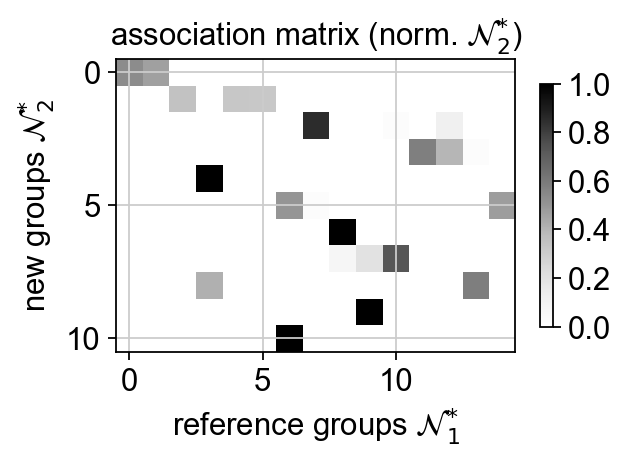

In [5]:
adata.obs['louvain_new'] = adata_new.obs['louvain']
result = sc.utils.compute_association_matrix_of_groups(adata, 'louvain_new', 'louvain')
sc.pl.matrix(result.asso_matrix, 
             xlabel='reference groups $\mathcal{N}_1^{*}$',
             ylabel='new groups $\mathcal{N}_2^{*}$', 
             title='association matrix (norm. $\mathcal{N}_2^{*}$)',
             save='_norm_new')

Or with respect to the reference groups (columns sum to 1).

saving figure to file ./figures/matrix_norm_reference.pdf


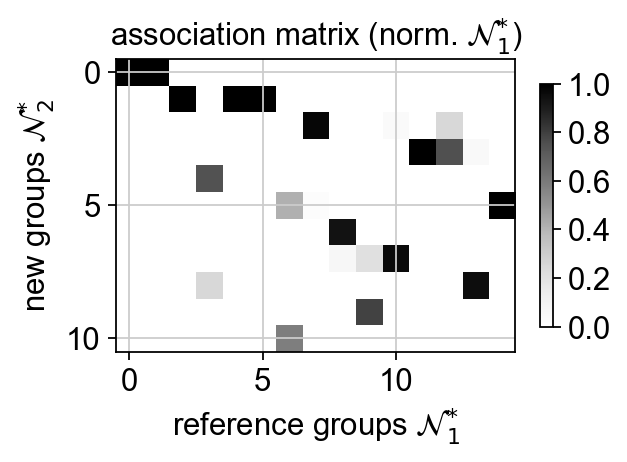

In [6]:
result = sc.utils.compute_association_matrix_of_groups(adata, 'louvain_new', 'louvain', normalization='reference')
sc.pl.matrix(result.asso_matrix,
             xlabel='reference groups $\mathcal{N}_1^{*}$',
             ylabel='new groups $\mathcal{N}_2^{*}$',              
             title='association matrix (norm. $\mathcal{N}_1^{*}$)',
             save='_norm_reference')

Now, for each reference group, we consider both normalizations when computing the overlap with each new group (walking along columns in the previous matrices). We then associate a reference group with the new group that maximizes the  minimal overlap between both normalizations.

... storing 'associated_new_groups' as categorical


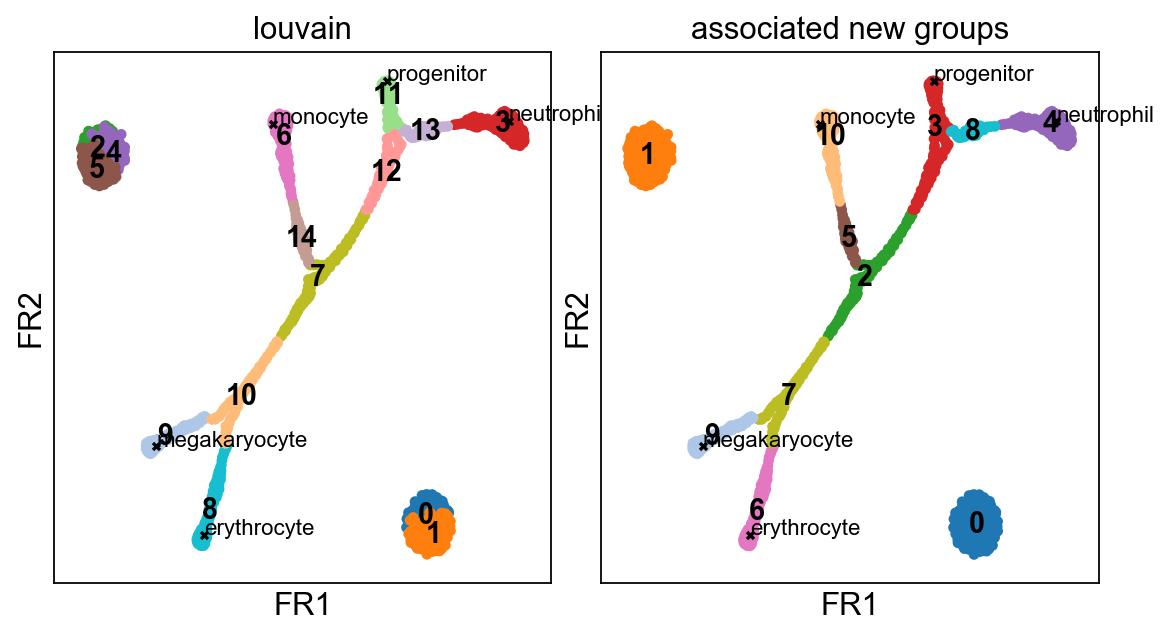

saving figure to file ./figures/draw_graph_fr_associated.pdf


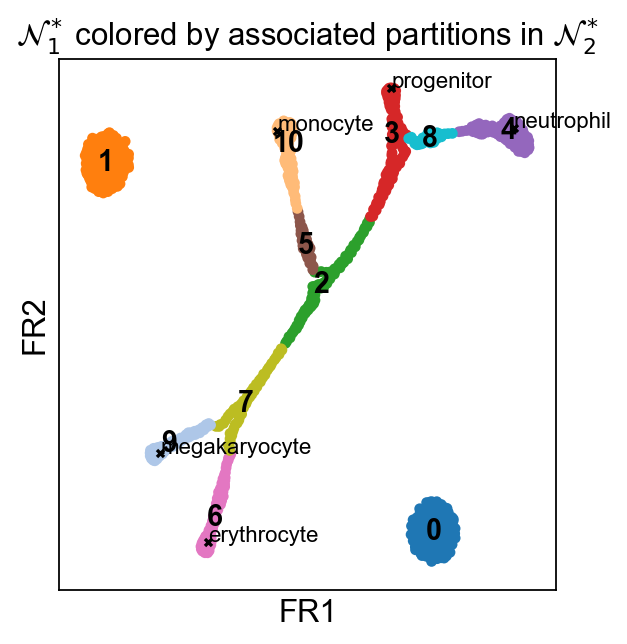

In [7]:
asso_groups_dict = sc.utils.identify_groups(adata.obs['louvain'], adata_new.obs['louvain'])
adata.obs['associated_new_groups'] = [asso_groups_dict[g][0] for g in adata.obs['louvain']]
sc.pl.draw_graph(adata, color=['louvain', 'associated_new_groups'], legend_loc='on data')
sc.pl.draw_graph(adata, color='associated_new_groups', legend_loc='on data',
                 title='$\mathcal{N}_1^*$ colored by associated partitions in $\mathcal{N}_2^*$',
                 save='_associated')

### 2. Compare paths between leaf nodes in both the reference graph and the new graph

Using the previous correspondence - the mapping of reference labels to new labels - we can compare the shortest paths between all leaf nodes in each abstracted graph.

If these agree, paths through groups in the reference and the new abstracted graph correspond to each other: both graphs have the same topology.

We measure deviations by counting how many steps and how many paths agree when averaging over all paths.

In [8]:
sc.settings.verbosity = 5  # increase to 6 for more output
result = sc.tl.paga_compare_paths(adata_reference, adata_new)
print(result)

leaf nodes in graph 1: ['0', '1', '3', '6', '8', '9']
compare shortest paths between leafs (0, 1) in graph1 and (0, 0) in graph2:
      path1 = ['0', '1'],
path_mapped = [['0'], ['0']],
      path2 = ['0'],
-> n_agreeing_steps = 0 / n_steps = 0.
compare shortest paths between leafs (0, 3) in graph1 and (0, 4) in graph2:
there are no connecting paths in both graphs
compare shortest paths between leafs (0, 6) in graph1 and (0, 10) in graph2:
there are no connecting paths in both graphs
compare shortest paths between leafs (0, 8) in graph1 and (0, 6) in graph2:
there are no connecting paths in both graphs
compare shortest paths between leafs (0, 9) in graph1 and (0, 9) in graph2:
there are no connecting paths in both graphs
compare shortest paths between leafs (1, 3) in graph1 and (0, 4) in graph2:
there are no connecting paths in both graphs
compare shortest paths between leafs (1, 6) in graph1 and (0, 10) in graph2:
there are no connecting paths in both graphs
compare shortest paths bet

## Sample a high number of conditions

Let us sample random parameters including combinations that lead completely unrealistic numbers of partitions.

In [9]:
sc.settings.verbosity = 1
statistics = OrderedDict([('nr. neighbors single-cell graph' , []), ('resolution louvain', []),
                          ('nr. louvain groups', []), ('total nr. steps in paths', []),
                          ('fraction of correct steps', []), ('fraction of correct paths', [])])
np.random.seed(0)
for i in range(100):
    n_neighbors = np.random.randint(5, 50)
    resolution = np.random.rand() * 5
    adata_new = sc.pp.neighbors(adata, n_neighbors=n_neighbors, copy=True)
    sc.tl.louvain(adata_new, resolution=resolution)
    sc.tl.paga(adata_new)
    result = sc.tl.paga_compare_paths(adata_reference, adata_new)
    # uncomment for visualization or output
    # axs = sc.pl.paga(adata_new, basis='draw_graph_fr', layout_graph='fr')
    # print('n_neighbors' , n_neighbors, 'resolution', resolution,
    #       'n_groups', len(adata_new.add['paga_groups_order']), 'frac_steps', result.frac_steps)
    statistics['nr. neighbors single-cell graph' ].append(n_neighbors)
    statistics['resolution louvain'].append(resolution)
    statistics['nr. louvain groups'].append(len(adata_new.obs['louvain'].cat.categories))
    statistics['total nr. steps in paths'].append(result.n_steps)        
    statistics['fraction of correct steps'].append(result.frac_steps)
    statistics['fraction of correct paths'].append(result.frac_paths)

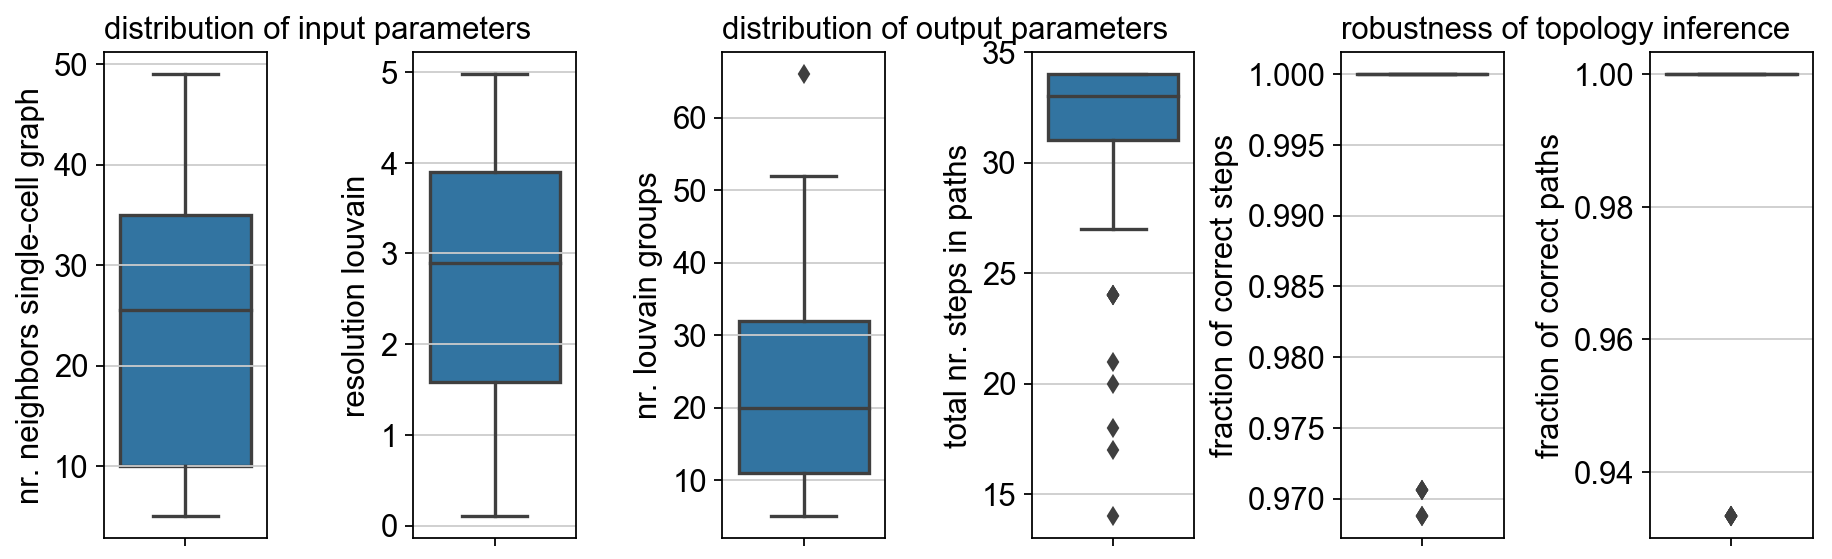

In [10]:
df = pd.DataFrame(statistics)
_, axs = pl.subplots(ncols=df.shape[1], figsize=(12, 4), gridspec_kw={'left': 0.07, 'wspace': 0.9})
for i, col in enumerate(df.columns):
    sns.boxplot(df[col], ax=axs[i], orient='vertical')
axs[0].set_title('distribution of input parameters', loc='left')
axs[2].set_title('distribution of output parameters', loc='left')
axs[4].set_title('robustness of topology inference', loc='left')
pl.savefig('./figures/robustness_summary.pdf', dpi=300)
pl.show()